In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats

# Summary Metrics and Visualizations

In [34]:
THRESHOLD = 0.5364887 # Best threshold from fine-tuning.

In [35]:
def clean_accent_name(accent):
    accent = accent.split("(")[0].strip()
    accent = " ".join([word.capitalize() for word in accent.split()])
    accent = accent.replace("&", "and")
    if accent == "Western Europe":
        return "Western Europe and South America" # Rename the Western Europe region to be more accurate. 
    if accent == "Sub-saharan Africa":
        return "Sub-Saharan Africa"
    return accent

def clean_gender_name(gender):
    return gender.split("_")[0]

def preprocess_results(results_df):
    results_df["region"] = results_df["region"].apply(clean_accent_name)
    results_df["gender"] = results_df["gender"].apply(clean_gender_name)
    results_df["predicted_spoof"] = (results_df["spoof_score"] > THRESHOLD).astype(int) # Or results["prediction_score"].
    results_df["actual_label"] = 1
    results_df["FP"] = (results_df["predicted_spoof"] == 1) & (results_df["actual_label"] == 1)
    results_df["TN"] = (results_df["predicted_spoof"] == 0) & (results_df["actual_label"] == 1)
    return results_df

In [40]:
def compute_region_metrics(results_df, model_name):
    region_metrics = results_df.groupby("region").agg(
        total_samples=("actual_label", "count"),
        false_positives=("FP", "sum"),
        true_negatives=("TN", "sum")
    )
    region_metrics["FPR"] = region_metrics["false_positives"] / region_metrics["total_samples"]
    region_metrics["TNR"] = region_metrics["true_negatives"] / region_metrics["total_samples"]
    region_metrics = region_metrics.reset_index()
    region_metrics["Model"] = model_name
    region_metrics = region_metrics.sort_values(by="region", ascending=True)
    return region_metrics

def compute_gender_metrics(results_df, model_name):
    gender_metrics = results_df.groupby("gender").agg(
        total_samples=("actual_label", "count"),
        false_positives=("FP", "sum"),
        true_negatives=("TN", "sum")
    )
    gender_metrics["FPR"] = gender_metrics["false_positives"] / gender_metrics["total_samples"]
    gender_metrics["TNR"] = gender_metrics["true_negatives"] / gender_metrics["total_samples"]
    gender_metrics = gender_metrics.reset_index()
    gender_metrics["Model"] = model_name
    gender_metrics = gender_metrics.sort_values(by="gender", ascending=True)
    return gender_metrics

In [37]:
def compute_mean_average_deviation(fpr_df):
    mean_value = fpr_df['FPR'].mean()
    absolute_diffs = abs(fpr_df['FPR'] - mean_value)
    return absolute_diffs.mean()

In [38]:
tssd_baseline = pd.read_csv("baseline-model/final-results-tssd.csv")
tssd_baseline = preprocess_results(tssd_baseline)
tssd_baseline = tssd_baseline[~tssd_baseline["region"].isin(["Caribbean"])] # Exclude Caribbean from evaluation due to lack of training data from this region.

tssd_finetune_2 = pd.read_csv("finetuned-model/final-results-tssd.csv")
tssd_finetune_2 = preprocess_results(tssd_finetune_2)
tssd_finetune_2 = tssd_finetune_2[~tssd_finetune_2["region"].isin(["Caribbean"])]

### Accent Analysis

In [25]:
region_metrics_baseline = compute_region_metrics(tssd_baseline, "Baseline")
region_metrics_finetune = compute_region_metrics(tssd_finetune_2, "Fine-tuned")

In [26]:
region_metrics_baseline

,region,total_samples,false_positives,true_negatives,FPR,TNR,Model
0,British Isles,100,97,3,0.970000,0.030000,Baseline
1,East Asia,100,92,8,0.920000,0.080000,Baseline
2,Middle East and Central Asia,92,82,10,0.891304,0.108696,Baseline
3,North America,100,97,3,0.970000,0.030000,Baseline
4,South Asia,100,98,2,0.980000,0.020000,Baseline
5,Southeast Asia,100,97,3,0.970000,0.030000,Baseline
6,Sub-Saharan Africa,100,93,7,0.930000,0.070000,Baseline
7,Western Europe and South America,100,87,13,0.870000,0.130000,Baseline


In [27]:
print("Average Absolute Difference from Mean:", compute_mean_average_deviation(region_metrics_baseline))

Average Absolute Difference from Mean: 0.03483695652173911


In [28]:
region_metrics_finetune

,region,total_samples,false_positives,true_negatives,FPR,TNR,Model
0,British Isles,100,37,63,0.370000,0.630000,Fine-tuned
1,East Asia,100,10,90,0.100000,0.900000,Fine-tuned
2,Middle East and Central Asia,92,10,82,0.108696,0.891304,Fine-tuned
3,North America,100,48,52,0.480000,0.520000,Fine-tuned
4,South Asia,100,46,54,0.460000,0.540000,Fine-tuned
5,Southeast Asia,100,34,66,0.340000,0.660000,Fine-tuned
6,Sub-Saharan Africa,100,39,61,0.390000,0.610000,Fine-tuned
7,Western Europe and South America,100,23,77,0.230000,0.770000,Fine-tuned


In [29]:
print("Average Absolute Difference from Mean:", compute_mean_average_deviation(region_metrics_finetune))

Average Absolute Difference from Mean: 0.12270380434782609


In [30]:
region_metrics_combined = pd.concat(
    [region_metrics_baseline, region_metrics_finetune],
    ignore_index=True
)

In [31]:
def compute_confidence_interval(proportion, total, confidence=0.95):
    """Compute the confidence interval for a proportion using the Wilson Score Interval."""
    if total == 0:
        return (0, 0)
    z = stats.norm.ppf((1 + confidence) / 2)
    p = proportion
    n = total
    center = (p + (z**2) / (2 * n)) / (1 + (z**2) / n)
    margin = (z * np.sqrt((p * (1 - p) / n) + (z**2) / (4 * n**2))) / (1 + (z**2) / n)
    return center - margin, center + margin

def apply_confidence_intervals(df):
    """Apply CI computation to both the FPR and TNR."""
    df["FPR_CI_Lower"], df["FPR_CI_Upper"] = zip(*df.apply(
        lambda row: compute_confidence_interval(row["FPR"], row["total_samples"]),
        axis=1
    ))
    df["TNR_CI_Lower"], df["TNR_CI_Upper"] = zip(*df.apply(
        lambda row: compute_confidence_interval(row["TNR"], row["total_samples"]),
        axis=1
    ))
    return df

# Apply confidence interval calculation to both models:
all_region_metrics = [region_metrics_baseline, region_metrics_finetune]
for i, df in enumerate(all_region_metrics):
    all_region_metrics[i] = apply_confidence_intervals(df)
region_metrics_baseline, region_metrics_finetune = all_region_metrics

# Combine both models into a single DataFrame:
combined_fpr = pd.concat([
    region_metrics_baseline[["region", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]],
    region_metrics_finetune[["region", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]]
], ignore_index=True)
combined_tnr = pd.concat([
    region_metrics_baseline[["region", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]],
    region_metrics_finetune[["region", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]]
], ignore_index=True)

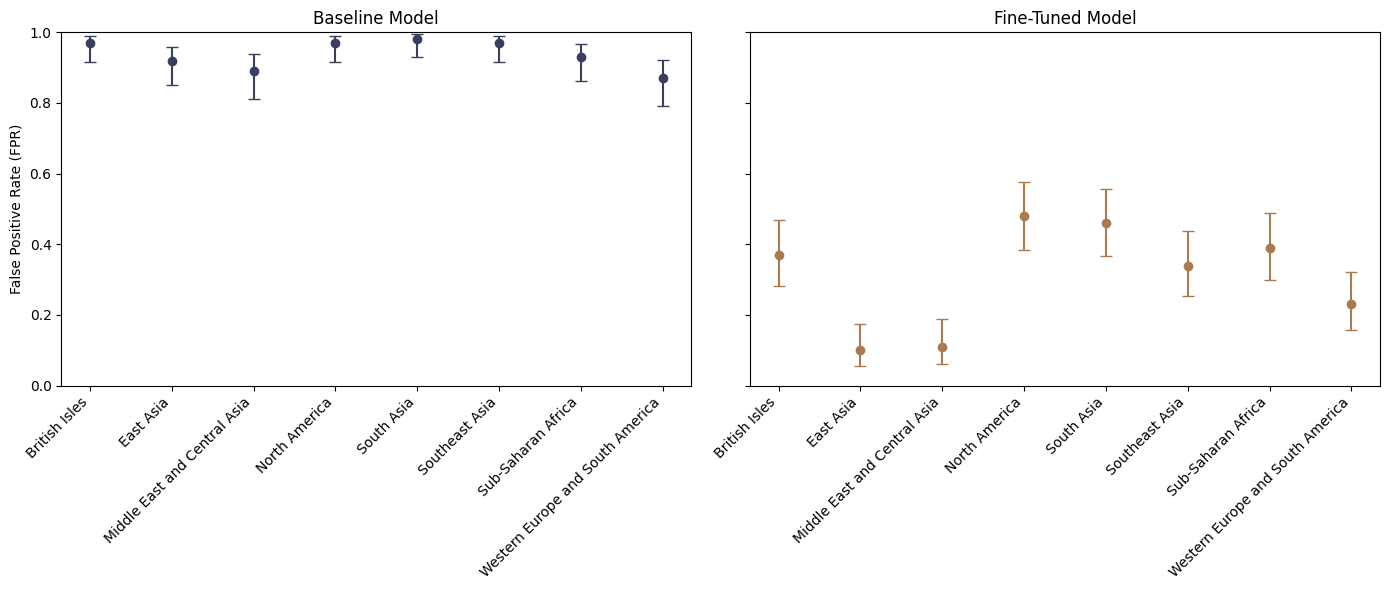

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Custom palette to match our presentation:
# model_colors = {
#     "Baseline": "#3a9593", 
#     "Fine-tuned": "#d9534f"
# }

# Custom palette to match our website:
model_colors = {
    "Baseline": "#3a3f5f", 
    "Fine-tuned": "#aa7b4f"
}

# Get list of regions for axis labels:
regions = sorted(combined_fpr["region"].unique())
region_to_index = {region: idx for idx, region in enumerate(regions)}

# Plot baseline results on left: 
model = "Baseline"
subset = combined_fpr[combined_fpr["Model"] == model]
x_positions = [region_to_index[r] for r in subset["region"]]
y = subset["FPR"]
yerr_lower = (y - subset["FPR_CI_Lower"]).clip(lower=0)
yerr_upper = (subset["FPR_CI_Upper"] - y).clip(lower=0)
axes[0].errorbar(x_positions, y, 
                 yerr=[yerr_lower, yerr_upper],
                 fmt="o", color=model_colors[model], capsize=4, label=model)
axes[0].set_title("Baseline Model")
axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].set_ylim(0, 1)

# Plot fine-tuned results on right:
model = "Fine-tuned"
subset = combined_fpr[combined_fpr["Model"] == model]
x_positions = [region_to_index[r] for r in subset["region"]]
y = subset["FPR"]
yerr_lower = (y - subset["FPR_CI_Lower"]).clip(lower=0)
yerr_upper = (subset["FPR_CI_Upper"] - y).clip(lower=0)
axes[1].errorbar(x_positions, y, 
                 yerr=[yerr_lower, yerr_upper],
                 fmt="o", color=model_colors[model], capsize=4, label=model)
axes[1].set_title("Fine-Tuned Model")
axes[1].set_ylim(0, 1)

# Set shared x-axis labels:
for ax in axes:
    ax.set_xticks(np.arange(len(regions)))
    ax.set_xticklabels(regions, rotation=45, ha="right")

plt.tight_layout()
plt.show()

### Gender Metrics

In [56]:
gender_metrics_baseline = compute_gender_metrics(tssd_baseline, "Baseline")
gender_metrics_finetune = compute_gender_metrics(tssd_finetune_2, "Fine-tuned")

In [57]:
gender_metrics_baseline

,gender,total_samples,false_positives,true_negatives,FPR,TNR,Model
0,female,396,359,37,0.906566,0.093434,Baseline
1,male,396,384,12,0.969697,0.030303,Baseline


In [58]:
print("Average Absolute Difference from Mean:", compute_mean_average_deviation(gender_metrics_baseline))

Average Absolute Difference from Mean: 0.031565656565656575


In [59]:
gender_metrics_finetune

,gender,total_samples,false_positives,true_negatives,FPR,TNR,Model
0,female,396,125,271,0.315657,0.684343,Fine-tuned
1,male,396,122,274,0.308081,0.691919,Fine-tuned


In [60]:
print("Average Absolute Difference from Mean:", compute_mean_average_deviation(gender_metrics_finetune))

Average Absolute Difference from Mean: 0.0037878787878787845


In [61]:
gender_metrics_combined = pd.concat(
    [gender_metrics_baseline, gender_metrics_finetune],
    ignore_index=True
)

In [62]:
# Apply confidence interval calculation to both models:
all_gender_metrics = [gender_metrics_baseline, gender_metrics_finetune]
for i, df in enumerate(all_gender_metrics):
    all_region_metrics[i] = apply_confidence_intervals(df)
gender_metrics_baseline, gender_metrics_finetune = all_region_metrics

# Combine both models into a single DataFrame:
combined_fpr = pd.concat([
    gender_metrics_baseline[["gender", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]],
    gender_metrics_finetune[["gender", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]]
], ignore_index=True)
combined_tnr = pd.concat([
    gender_metrics_baseline[["gender", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]],
    gender_metrics_finetune[["gender", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]]
], ignore_index=True)

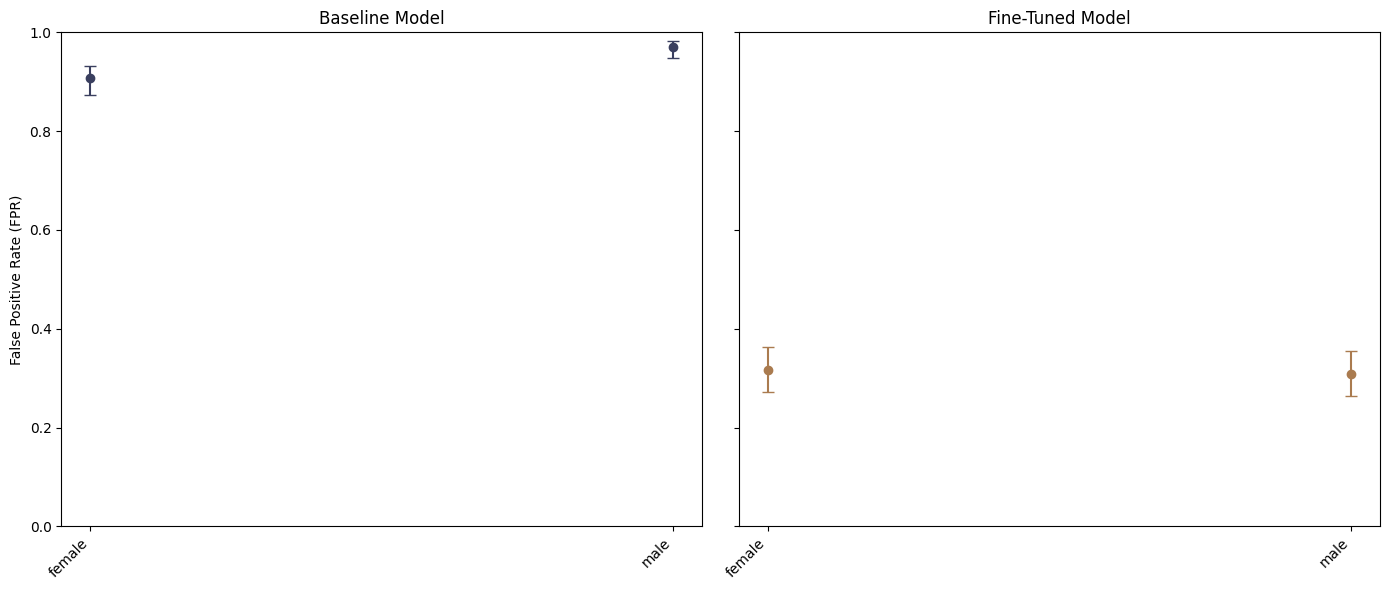

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Custom palette to match our presentation:
# model_colors = {
#     "Baseline": "#3a9593", 
#     "Fine-tuned": "#d9534f"
# }

# Custom palette to match our website:
model_colors = {
    "Baseline": "#3a3f5f", 
    "Fine-tuned": "#aa7b4f"
}

# Get list of regions for axis labels:
genders = sorted(combined_fpr["gender"].unique())
gender_to_index = {gender: idx for idx, gender in enumerate(genders)}

# Plot baseline results on left: 
model = "Baseline"
subset = combined_fpr[combined_fpr["Model"] == model]
x_positions = [gender_to_index[g] for g in subset["gender"]]
y = subset["FPR"]
yerr_lower = (y - subset["FPR_CI_Lower"]).clip(lower=0)
yerr_upper = (subset["FPR_CI_Upper"] - y).clip(lower=0)
axes[0].errorbar(x_positions, y, 
                 yerr=[yerr_lower, yerr_upper],
                 fmt="o", color=model_colors[model], capsize=4, label=model)
axes[0].set_title("Baseline Model")
axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].set_ylim(0, 1)

# Plot fine-tuned results on right:
model = "Fine-tuned"
subset = combined_fpr[combined_fpr["Model"] == model]
x_positions = [gender_to_index[g] for g in subset["gender"]]
y = subset["FPR"]
yerr_lower = (y - subset["FPR_CI_Lower"]).clip(lower=0)
yerr_upper = (subset["FPR_CI_Upper"] - y).clip(lower=0)
axes[1].errorbar(x_positions, y, 
                 yerr=[yerr_lower, yerr_upper],
                 fmt="o", color=model_colors[model], capsize=4, label=model)
axes[1].set_title("Fine-Tuned Model")
axes[1].set_ylim(0, 1)

# Set shared x-axis labels:
for ax in axes:
    ax.set_xticks(np.arange(len(genders)))
    ax.set_xticklabels(genders, rotation=45, ha="right")

plt.tight_layout()
plt.show()